## Train an AutoML model to classify IoT signals

In [24]:
pip install -r requirements.txt --ignore-installed

In [ ]:
# First, we'll import pandas, a data processing and CSV file I/O library
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd; print(f"pandas=={pd.__version__}")
import numpy as np
import seaborn as sns
sns.set_theme(style="white", context="talk")
import matplotlib.pyplot as plt

In [2]:
data_path = "s3://shakdemo-aws/data/iot/iot_telemetry_data.csv"
label = 'motion'

In [4]:
data = pd.read_csv(data_path) 
print(data.shape)
data.head(2)

(405184, 9)


,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.0,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.0,False,0.005114,False,0.013275,19.700001


<a href="#results">Go to Results</a>

In [5]:
data[label].value_counts(normalize= True)

False    0.99881
True     0.00119
Name: motion, dtype: float64

In [6]:
y = data[label]
X = data.drop([label, 'device'], axis= 1)
y.shape, X.shape

((405184,), (405184, 7))

In [7]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
X.shape, y.shape

((809404, 7), (809404,))

In [8]:
data = pd.concat([X, y], axis = 1)
data.shape

(809404, 8)

In [9]:
data[label].value_counts(normalize= True)

False    0.5
True     0.5
Name: motion, dtype: float64

(40.0, 80.0)

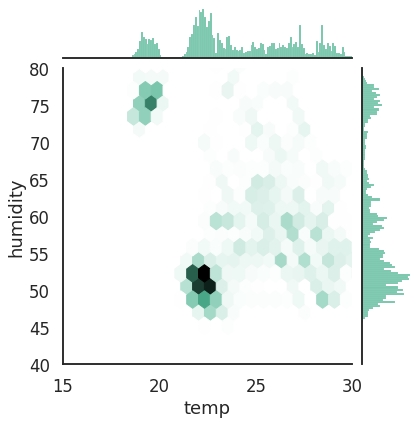

In [10]:
sns.jointplot(x=data.temp, y=data.humidity, kind="hex", color="#4CB391")
plt.xlim(15, 30)
plt.ylim(40, 80)

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.2)
print(train.shape, test.shape)
print(f"distribution of labels in train: {train[label].value_counts(normalize = True)}")
print(f"distribution of labels in test:  {test[label].value_counts(normalize = True)}")

(647523, 8) (161881, 8)
distribution of labels in train: True     0.500123
False    0.499877
Name: motion, dtype: float64
distribution of labels in test:  False    0.500491
True     0.499509
Name: motion, dtype: float64


## Train and select model automatically with AutoGluon
AutoGluon enables easy-to-use and easy-to-extend AutoML with a focus on automated stack ensembling, deep learning, and real-world applications spanning text, image, and tabular data. 

In [12]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [13]:
train_data = TabularDataset(train)
subsample_size = 1000  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.shape)
train_data.head(2)

(1000, 8)


,ts,co,humidity,light,lpg,smoke,temp,motion
242848,1.594926e+09,0.006207,50.200000,False,0.009004,0.024289,21.6,False
154957,1.594777e+09,0.004674,59.599998,True,0.007333,0.019507,25.0,False


In [14]:
%%time
save_path = f"models"
predictor = TabularPredictor(label=label, path=save_path, eval_metric = 'f1_weighted').fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "models/"
AutoGluon Version:  0.5.2
Python Version:     3.8.10
Operating System:   Linux
Train Data Rows:    1000
Train Data Columns: 7
Label Column: motion
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [False, True]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14264.36 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the fea

CPU times: user 27.8 s, sys: 1.37 s, total: 29.1 s
Wall time: 10.5 s


In [15]:
result = predictor.leaderboard(train_data.dropna(subset =[label]), silent=True)
result

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.977000,0.890000,0.002208,0.001870,1.017290,0.002208,0.001870,1.017290,1,True,7
1,RandomForestGini,0.975000,0.874953,0.085942,0.055055,0.461376,0.085942,0.055055,0.461376,1,True,5
2,RandomForestEntr,0.974999,0.874803,0.085858,0.051774,0.467206,0.085858,0.051774,0.467206,1,True,6
3,LightGBMLarge,0.974000,0.880000,0.004583,0.015908,1.066322,0.004583,0.015908,1.066322,1,True,13
4,ExtraTreesGini,0.974000,0.869922,0.086510,0.054189,0.480752,0.086510,0.054189,0.480752,1,True,8
5,ExtraTreesEntr,0.971000,0.854989,0.086658,0.052582,0.453593,0.086658,0.052582,0.453593,1,True,9
6,WeightedEnsemble_L2,0.955988,0.909946,0.105279,0.067782,4.384229,0.003243,0.001130,1.044353,2,True,14
7,KNeighborsDist,0.953998,0.769539,0.006634,0.005631,0.003492,0.006634,0.005631,0.003492,1,True,2
8,XGBoost,0.927975,0.889978,0.005122,0.005407,0.551961,0.005122,0.005407,0.551961,1,True,11
9,LightGBMXT,0.924976,0.889978,0.009945,0.003217,1.412318,0.009945,0.003217,1.412318,1,True,3


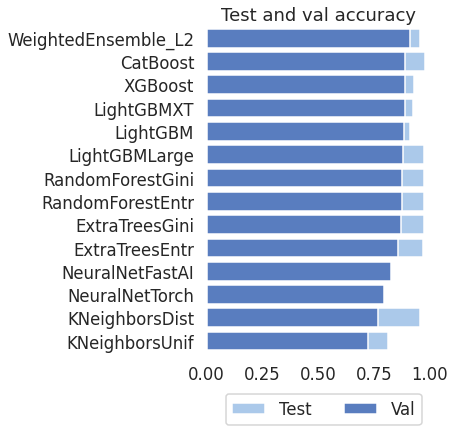

In [16]:
result = result.sort_values('score_val', ascending = False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(4,6))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="score_test", y="model", data=result, label="Test", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="score_val", y="model", data=result, label="Val", color="b")

# # Add a legend and informative axis label
ax.legend(ncol=2,frameon=True, bbox_to_anchor=(1, -0.1))
ax.set(xlim=(0, 1), ylabel="", xlabel ="", title="Test and val accuracy")
sns.despine(left=True, bottom=True)

## Inference with the trained model

In [17]:
test_data = TabularDataset(test)
test_data = test_data.dropna(subset = [label])
print(test_data.shape)
y_test = test_data[label]  # values to predict
test_data_nolab = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
test_data_nolab.head(2)

(161881, 8)


,ts,co,humidity,light,lpg,smoke,temp
414822,1.594753e+09,0.004906,51.530168,True,0.007594,0.020251,23.282554
459625,1.595000e+09,0.003995,68.963702,True,0.006546,0.017279,26.022064


In [18]:
predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred.value_counts())
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Predictions:  
 True     84105
False    77776
Name: motion, dtype: int64


Evaluation: f1_weighted on test data: 0.8704727087640898
Evaluations on test data:
{
    "f1_weighted": 0.8704727087640898,
    "accuracy": 0.8705221736954923,
    "balanced_accuracy": 0.8705417315739452,
    "mcc": 0.7416501455263177,
    "f1": 0.8729435156335243,
    "precision": 0.8561084358837168,
    "recall": 0.8904539889439903
}


<a id='results'></a>

In [19]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.883191,0.890000,0.032234,0.001870,1.017290,0.032234,0.001870,1.017290,1,True,7
1,ExtraTreesEntr,0.877233,0.854989,0.854819,0.052582,0.453593,0.854819,0.052582,0.453593,1,True,9
2,ExtraTreesGini,0.876802,0.869922,0.857360,0.054189,0.480752,0.857360,0.054189,0.480752,1,True,8
3,RandomForestEntr,0.872547,0.874803,0.876315,0.051774,0.467206,0.876315,0.051774,0.467206,1,True,6
4,RandomForestGini,0.871368,0.874953,0.748444,0.055055,0.461376,0.748444,0.055055,0.461376,1,True,5
5,WeightedEnsemble_L2,0.870473,0.909946,1.629099,0.067782,4.384229,0.005633,0.001130,1.044353,2,True,14
6,LightGBMLarge,0.870160,0.880000,0.170819,0.015908,1.066322,0.170819,0.015908,1.066322,1,True,13
7,XGBoost,0.863347,0.889978,0.073676,0.005407,0.551961,0.073676,0.005407,0.551961,1,True,11
8,LightGBMXT,0.856236,0.889978,0.864525,0.003217,1.412318,0.864525,0.003217,1.412318,1,True,3
9,LightGBM,0.853288,0.884899,0.055674,0.002223,0.558659,0.055674,0.002223,0.558659,1,True,4


In [20]:
feature_importance = predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...
	6.64s	= Expected runtime (1.33s per shuffle set)
	3.14s	= Actual runtime (Completed 5 of 5 shuffle sets)


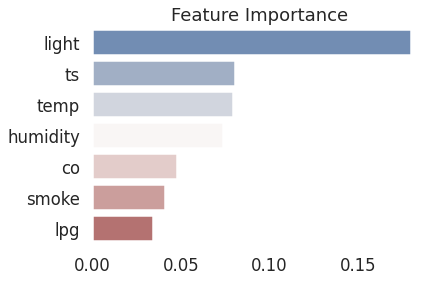

In [21]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6,4))
sns.barplot(x="importance", y="index", palette="vlag", data=feature_importance.reset_index())
ax.set(ylabel="", xlabel ="", title="Feature Importance")
sns.despine(left=True, bottom=True)

## save model to Cloud for inference

In [22]:
def upload_to_cloud(local_file_name, remote_file_name):
    import os
    import s3fs
    import gcsfs
    cloud_name = remote_file_name.split('://')[0]
    if cloud_name =='gs':
        fs = gcsfs.GCSFileSystem(project=os.environ['GCP_PROJECT'])
    elif cloud_name =='s3':
        fs = s3fs.S3FileSystem()
    else:
        raise NameError(f'cloud name {cloud_name} unknown')
    try:    
        print(f'uploading {local_file_name} to {remote_file_name} ...')
        fs.put(local_file_name, remote_file_name, recursive=True)
        print("done uploading!")
    except Exception as exp:
        print(f"upload failed: {exp}")
        
    return 

In [23]:
model_file_path = 'models'
remote_file_path = f"s3://shakdemo-aws/demo/iot/{model_file_path}"
upload_to_cloud(model_file_path, remote_file_path)

uploading models to s3://shakdemo-aws/demo/iot/models ...
done uploading!
